# Examples

This Jupyter notebook shows examples for the different functions of the module `zaf`.

Functions:
- [stft - Short-time Fourier transform (STFT)](#stft)
- [istft - Inverse STFT](#istft)
- [cqtkernel - Constant-Q transform (CQT) kernel](#cqtkernel)
- [cqtspectrogram - CQT spectrogram using a CQT kernel](#cqtspectrogram)
- [cqtchromagram - CQT chromagram using a CQT kernel](#cqtchromagram)
- [mfcc - Mel frequency cepstrum coefficients (MFCCs)](#mfcc)
- [dct - Discrete cosine transform (DCT) using the fast Fourier transform (FFT)](#dct)
- [dst - Discrete sine transform (DST) using the FFT](#dst)
- [mdct - Modified discrete cosine transform (MDCT) using the FFT](#mdct)
- [imdct - Inverse MDCT using the FFT](#imdct)

Author:
-  Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 09/13/20

## <a id="stft"></a>Short-time Fourier transform (STFT)

```
stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal [number_samples, 0]
    window_function: window function [window_length, 0]
    step_length: step length in samples
Output:
    audio_stft: audio STFT [window_length, number_frames]
```

### Compute and display the spectrogram from an audio file

In [1]:
# Import modules
import scipy.io.wavfile
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the audio signal, normalize it (SciPy's wavfile.read is not normalized), and average it over its channels
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (np.power(2, audio_signal.itemsize*8 - 1)
audio_signal = np.mean(audio_signal, 1)

# Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04

# Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = int(np.power(2, np.ceil(np.log2(window_duration * sample_rate))))

# Compute the window function (use SciPy's periodic Hamming window for COLA; NumPy's Hamming window is symmetric)
window_function = scipy.signal.hamming(window_length, False)

# Set the step length in samples (half of the window length for COLA)
step_length = (window_length/2).astype(int)

# Magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_stft = z.stft(audio_signal, window_function, step_length)
audio_spectrogram = np.absolute(audio_stft[1:int(window_length/2+1), :])

# Spectrogram displayed in dB, s, and kHz
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(20*np.log10(audio_spectrogram), aspect='auto', cmap='jet', origin='lower')
plt.title('Spectrogram (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/step_length),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.round(np.arange(1e3, sample_rate/2+1, 1e3)/sample_rate*window_length),
           np.arange(1, int(sample_rate/2*1e3)+1))
plt.ylabel('Frequency (kHz)')
plt.show()

IndentationError: expected an indented block (zaf.py, line 186)

## <a id="istft"></a>Inverse short-time Fourier transform (STFT)

```
import z
audio_signal = z.istft(audio_stft, window_function, step_length)
```

Arguments:

```
audio_stft: audio STFT [window_length, number_frames]
window_function: window function [window_length, 0]
step_length: step length in samples
audio_signal: audio signal [number_samples, 0]
```

### Estimate the center and sides signals of a stereo audio file

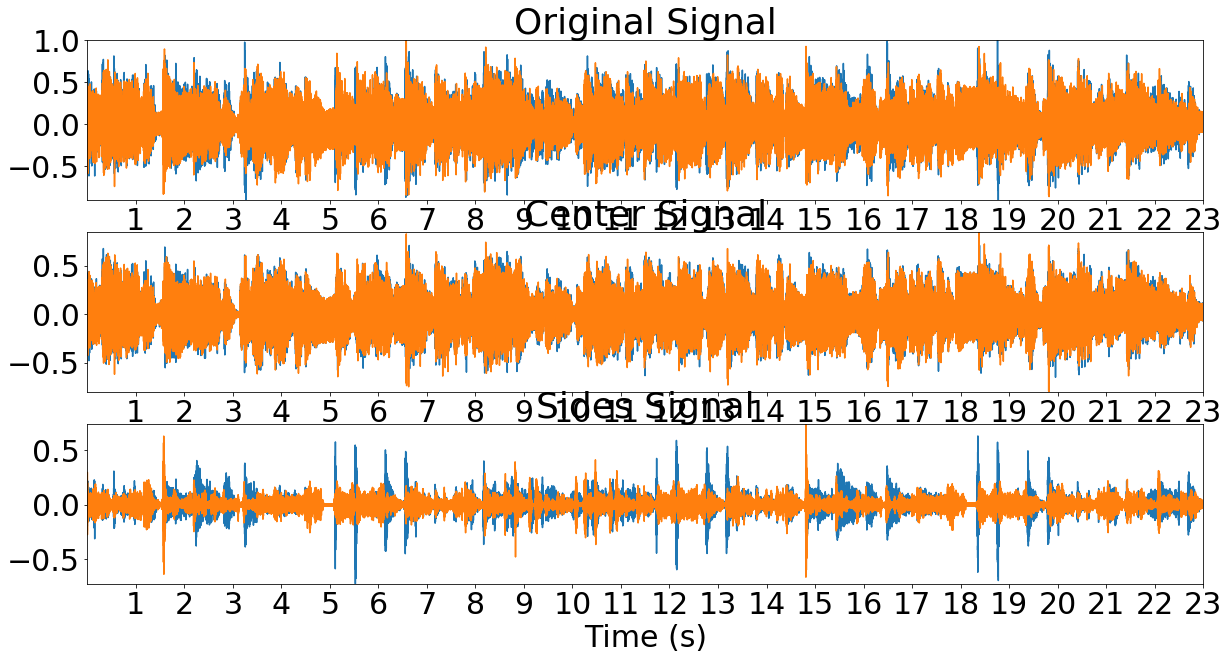

In [2]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import scipy.signal
import z

# Stereo audio signal (normalized) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))

# Parameters for the STFT
window_duration = 0.04
window_length = int(2**np.ceil(np.log2(window_duration*sample_rate)))
window_function = scipy.signal.hamming(window_length, False)
step_length = int(window_length/2)

# STFT of the left and right channels
audio_stft1 = z.stft(audio_signal[:, 0], window_function, step_length)
audio_stft2 = z.stft(audio_signal[:, 1], window_function, step_length)

# Magnitude spectrogram (with DC component) of the left and right channels
audio_spectrogram1 = abs(audio_stft1[0:int(window_length/2)+1, :])
audio_spectrogram2 = abs(audio_stft2[0:int(window_length/2)+1, :])

# Time-frequency masks of the left and right channels for the center signal
center_mask1 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram1
center_mask2 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram2

# STFT of the left and right channels for the center signal (with extension to mirrored frequencies)
center_stft1 = np.multiply(np.concatenate((center_mask1, center_mask1[int(window_length/2)-1:0:-1, :])),
                           audio_stft1)
center_stft2 = np.multiply(np.concatenate((center_mask2, center_mask2[int(window_length/2)-1:0:-1, :])),
                           audio_stft2)

# Synthesized signals of the left and right channels for the center signal
center_signal1 = z.istft(center_stft1, window_function, step_length)
center_signal2 = z.istft(center_stft2, window_function, step_length)

# Final stereo center and sides signals
center_signal = np.stack((center_signal1, center_signal2), 1)
center_signal = center_signal[0:len(audio_signal), :]
sides_signal = audio_signal-center_signal

# Synthesized center and side signals (un-normalized)
scipy.io.wavfile.write('center_signal.wav', sample_rate, center_signal)
scipy.io.wavfile.write('sides_signal.wav', sample_rate, sides_signal)

# Original, center, and sides signals displayed in s
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(3, 1, 1), plt.plot(audio_signal), plt.autoscale(tight=True), plt.title("Original Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 2), plt.plot(center_signal), plt.autoscale(tight=True), plt.title("Center Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 3), plt.plot(sides_signal), plt.autoscale(tight=True), plt.title("Sides Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.show()

### <a id="cqtkernel"></a>cqtkernel Constant-Q transform (CQT) kernel

```
import z
cqt_kernel = z.cqtkernel(sample_rate, frequency_resolution, minimum_frequency, maximum_frequency)
```

Arguments:

```
sample_rate: sample rate in Hz
frequency_resolution: frequency resolution in number of frequency channels per semitone
minimum_frequency: minimum frequency in Hz
maximum_frequency: maximum frequency in Hz
CQT kernel [number_frequencies, fft_length]
```

Example: Compute and display the CQT kernel

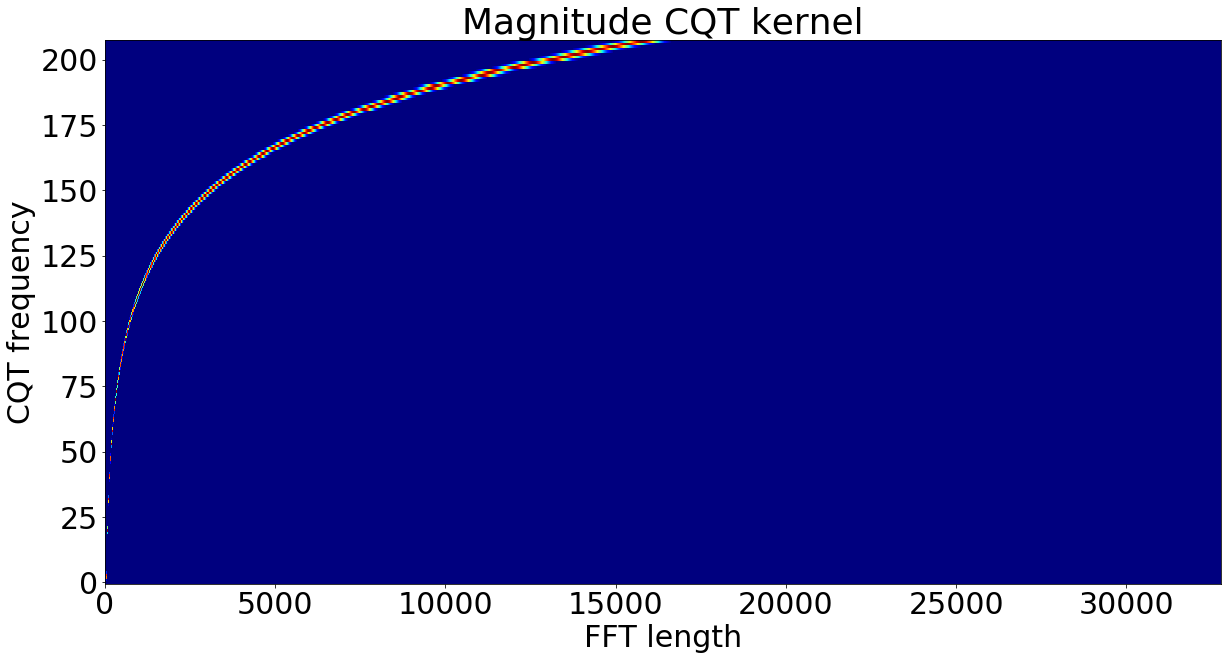

In [3]:
%matplotlib inline

# Import modules
import z
import numpy as np
import matplotlib.pyplot as plt

# CQT kernel parameters
sample_rate = 44100
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = sample_rate/2

# CQT kernel
cqt_kernel = z.cqtkernel(sample_rate, frequency_resolution, minimum_frequency, maximum_frequency)

# Magnitude CQT kernel displayed
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(np.absolute(cqt_kernel).toarray(), aspect='auto', cmap='jet', origin='lower')
plt.title('Magnitude CQT kernel')
plt.xlabel('FFT length')
plt.ylabel('CQT frequency')
plt.show()

### <a id="cqtspectrogram"></a>cqtspectrogram Constant-Q transform (CQT) spectrogram using a CQT kernel

```
import z
audio_spectrogram = z.cqtspectrogram(audio_signal, sample_rate, time_resolution, cqt_kernel)
```

Arguments:

```
audio_signal: audio signal [number_samples, 0]
sample_rate: sample rate in Hz
time_resolution: time resolution in number of time frames per second
cqt_kernel: CQT kernel [number_frequencies, fft_length]
audio_spectrogram: audio spectrogram in magnitude [number_frequencies, number_times]
```

Example: Compute and display the CQT spectrogram

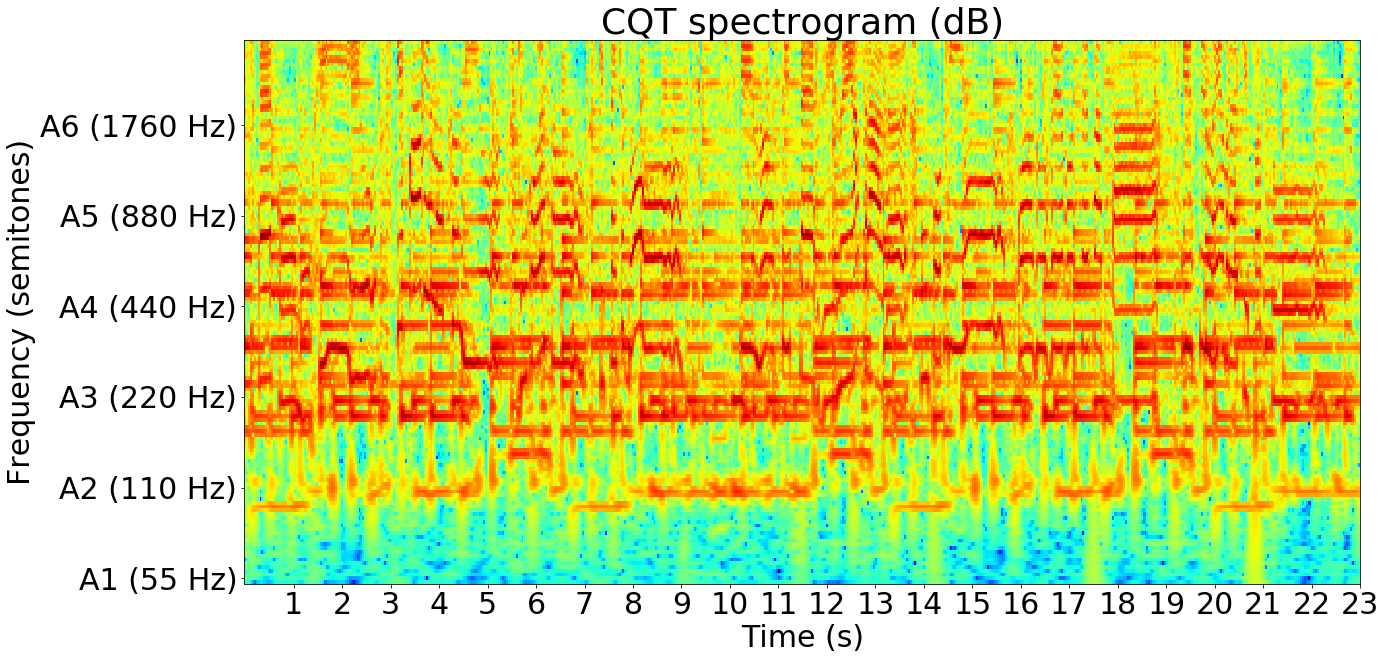

In [4]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio file (normalized) averaged over the channels and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / ( 2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# CQT kernel
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = z.cqtkernel(sample_rate, frequency_resolution, minimum_frequency, maximum_frequency)

# CQT spectrogram
time_resolution = 25
audio_spectrogram = z.cqtspectrogram(audio_signal, sample_rate, time_resolution, cqt_kernel)

# CQT spectrogram displayed in dB, s, and semitones
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(20*np.log10(audio_spectrogram), aspect='auto', cmap='jet', origin='lower')
plt.title('CQT spectrogram (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*time_resolution),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.arange(1, 6*12*frequency_resolution+1, 12*frequency_resolution),
           ('A1 (55 Hz)','A2 (110 Hz)','A3 (220 Hz)','A4 (440 Hz)','A5 (880 Hz)','A6 (1760 Hz)'))
plt.ylabel('Frequency (semitones)')
plt.show()

### <a id="cqtchromagram"></a>cqtchromagram Constant-Q transform (CQT) chromagram using a CQT kernel

```
import z
audio_chromagram = z.cqtchromagram(audio_signal, sample_rate, time_resolution, frequency_resolution, cqt_kernel)
```

Arguments:

```
audio_signal: audio signal [number_samples,1]
sample_rate: sample rate in Hz
time_resolution: time resolution in number of time frames per second
frequency_resolution: frequency resolution in number of frequency channels per semitones
cqt_kernel: CQT kernel [number_frequencies,fft_length]
audio_chromagram: audio chromagram [number_chromas,number_times]
```

Example: Compute and display the CQT chromagram

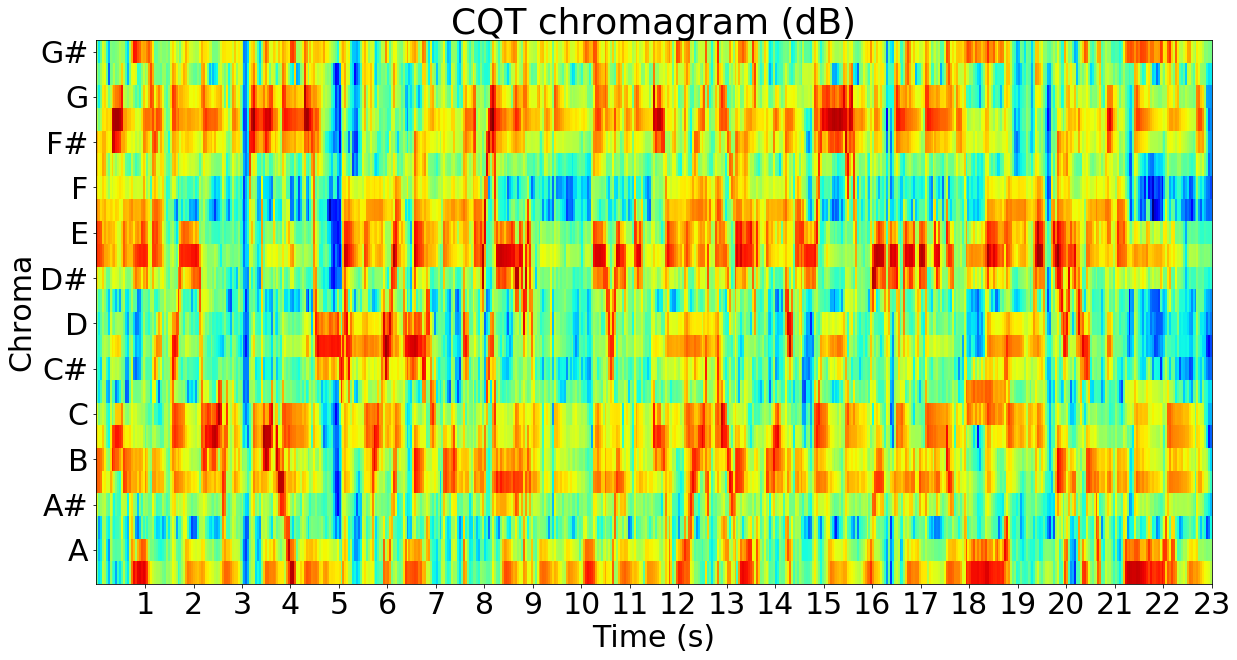

In [5]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# CQT kernel
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = z.cqtkernel(sample_rate, frequency_resolution, minimum_frequency, maximum_frequency)

# CQT chromagram
time_resolution = 25
audio_chromagram = z.cqtchromagram(audio_signal, sample_rate, time_resolution, frequency_resolution, cqt_kernel)

# CQT chromagram displayed in dB, s, and chromas
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(20*np.log10(audio_chromagram), aspect='auto', cmap='jet', origin='lower')
plt.title('CQT chromagram (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*time_resolution),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.arange(1, 12*frequency_resolution+1, frequency_resolution),
           ('A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'))
plt.ylabel('Chroma')
plt.show()

### <a id="mfcc"></a>mfcc Mel frequency cepstrum coefficients (MFCCs)

```
import z
audio_mfcc = z.mfcc(audio_signal, sample_rate, number_filters, number_coefficients)
```

Arguments:

```
audio_signal: audio signal [number_samples, 0]
sample_rate: sample rate in Hz
number_filters: number of filters
number_coefficients: number of coefficients (without the 0th coefficient)
audio_mfcc: audio MFCCs [number_times, number_coefficients]
```

Example: Compute and display the MFCCs, delta MFCCs, and delta-detla MFCCs

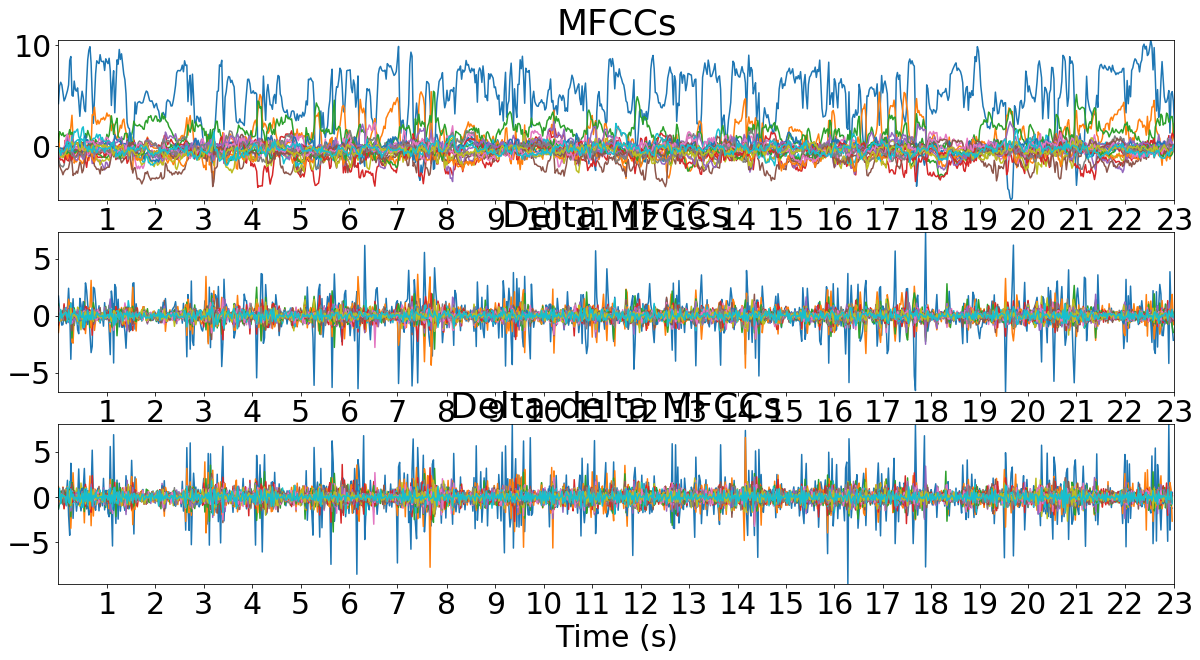

In [6]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# MFCCs for a given number of filters and coefficients
number_filters = 40
number_coefficients = 20
audio_mfcc = z.mfcc(audio_signal, sample_rate, number_filters, number_coefficients)

# Delta and delta-delta MFCCs
audio_deltamfcc = np.diff(audio_mfcc, n=1, axis=1)
audio_deltadeltamfcc = np.diff(audio_deltamfcc, n=1, axis=1)

# MFCCs, delta MFCCs, and delta-delta MFCCs displayed in s
step_length = 2**np.ceil(np.log2(0.04*sample_rate)) / 2
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(3, 1, 1), plt.plot(np.transpose(audio_mfcc)), plt.autoscale(tight=True), plt.title('MFCCs')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/step_length),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 2), plt.plot(np.transpose(audio_deltamfcc)), plt.autoscale(tight=True), plt.title('Delta MFCCs')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/step_length),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 3), plt.plot(np.transpose(audio_deltadeltamfcc)), plt.autoscale(tight=True), plt.title('Delta-delta MFCCs')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/step_length),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.show()

### <a id="dct"></a>dct Discrete cosine transform (DCT) using the fast Fourier transform (FFT)

```
import z
audio_dct = z.dct(audio_signal, dct_type)
```

Arguments:

```
audio_signal: audio signal [number_samples, number_frames] (number_frames>0)
dct_type: dct type (1, 2, 3, or 4)
audio_dct: audio DCT [number_frequencies, number_frames]
```

Example: Compute the 4 different DCTs and compare them to SciPy's DCTs

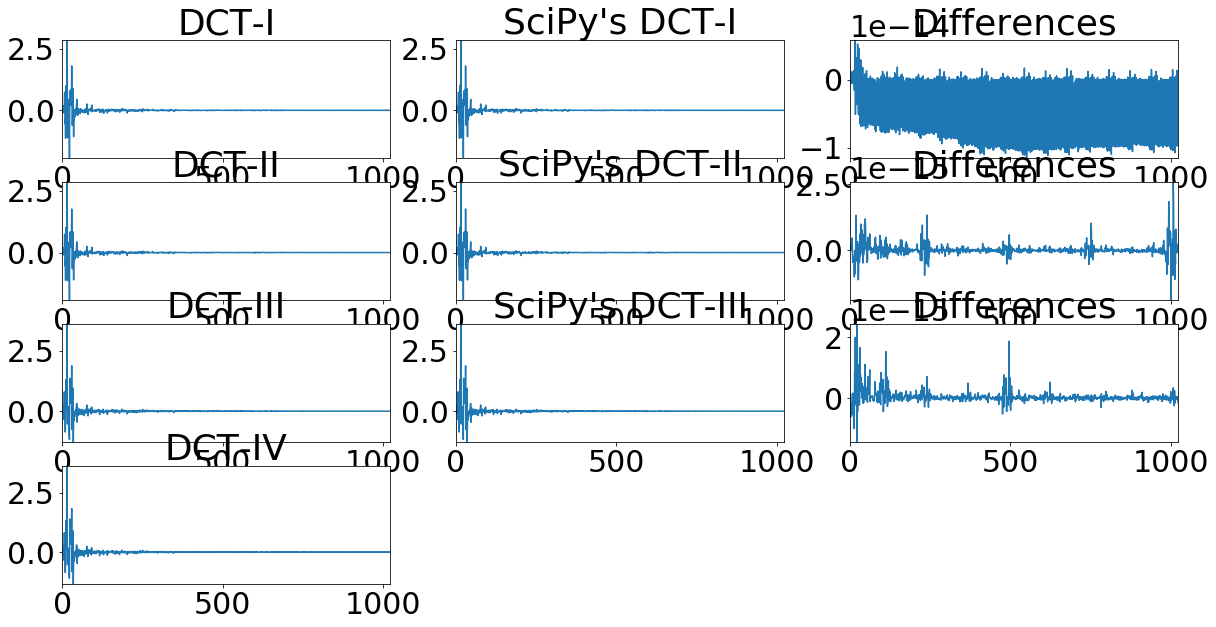

In [7]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import scipy.fftpack
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)
audio_signal = np.expand_dims(audio_signal, axis=1)

# Audio signal for a given window length, and one frame
window_length = 1024
audio_signal = audio_signal[0:window_length, :]

# DCT-I, II, III, and IV
audio_dct1 = z.dct(audio_signal, 1)
audio_dct2 = z.dct(audio_signal, 2)
audio_dct3 = z.dct(audio_signal, 3)
audio_dct4 = z.dct(audio_signal, 4)

# SciPy's DCT-I (orthogonalized), II, and III (SciPy does not have a DCT-IV!)
audio_signal1 = np.concatenate((audio_signal[0:1, :]*np.sqrt(2), audio_signal[1:window_length-1, :],
                               audio_signal[window_length-1:window_length, :]*np.sqrt(2)))
scipy_dct1 = scipy.fftpack.dct(audio_signal1, axis=0, type=1)
scipy_dct1[[0, window_length-1], :] = scipy_dct1[[0, window_length-1], :]/np.sqrt(2)
scipy_dct1 = scipy_dct1*np.sqrt(2/(window_length-1)) / 2
scipy_dct2 = scipy.fftpack.dct(audio_signal, axis=0, type=2, norm='ortho')
scipy_dct3 = scipy.fftpack.dct(audio_signal, axis=0, type=3, norm='ortho')

# DCT-I, II, III, and IV, Matlab's versions, and their differences displayed
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(4, 3, 1), plt.plot(audio_dct1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(4, 3, 2), plt.plot(scipy_dct1), plt.autoscale(tight=True), plt.title("SciPy's DCT-I")
plt.subplot(4, 3, 3), plt.plot(audio_dct1-scipy_dct1), plt.autoscale(tight=True), plt.title("Differences")
plt.subplot(4, 3, 4), plt.plot(audio_dct2), plt.autoscale(tight=True), plt.title("DCT-II")
plt.subplot(4, 3, 5), plt.plot(scipy_dct2), plt.autoscale(tight=True), plt.title("SciPy's DCT-II")
plt.subplot(4, 3, 6), plt.plot(audio_dct2-scipy_dct2), plt.autoscale(tight=True), plt.title("Differences")
plt.subplot(4, 3, 7), plt.plot(audio_dct3), plt.autoscale(tight=True), plt.title("DCT-III")
plt.subplot(4, 3, 8), plt.plot(scipy_dct3), plt.autoscale(tight=True), plt.title("SciPy's DCT-III")
plt.subplot(4, 3, 9), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("Differences")
plt.subplot(4, 3, 10), plt.plot(audio_dct4), plt.autoscale(tight=True), plt.title("DCT-IV")
plt.show()

### <a id="dst"></a>dst Discrete sine transform (DST) using the fast Fourier transform (FFT)

```
import z
audio_dst = z.dst(audio_signal, dst_type)
```

Arguments:

```
audio_signal: audio signal [number_samples, number_frames] (number_frames>0)
dst_type: DST type (1, 2, 3, or 4)
audio_dst: audio DST [number_frequencies, number_frames]
```

Example: Compute the 4 different DSTs and compare them to their respective inverses

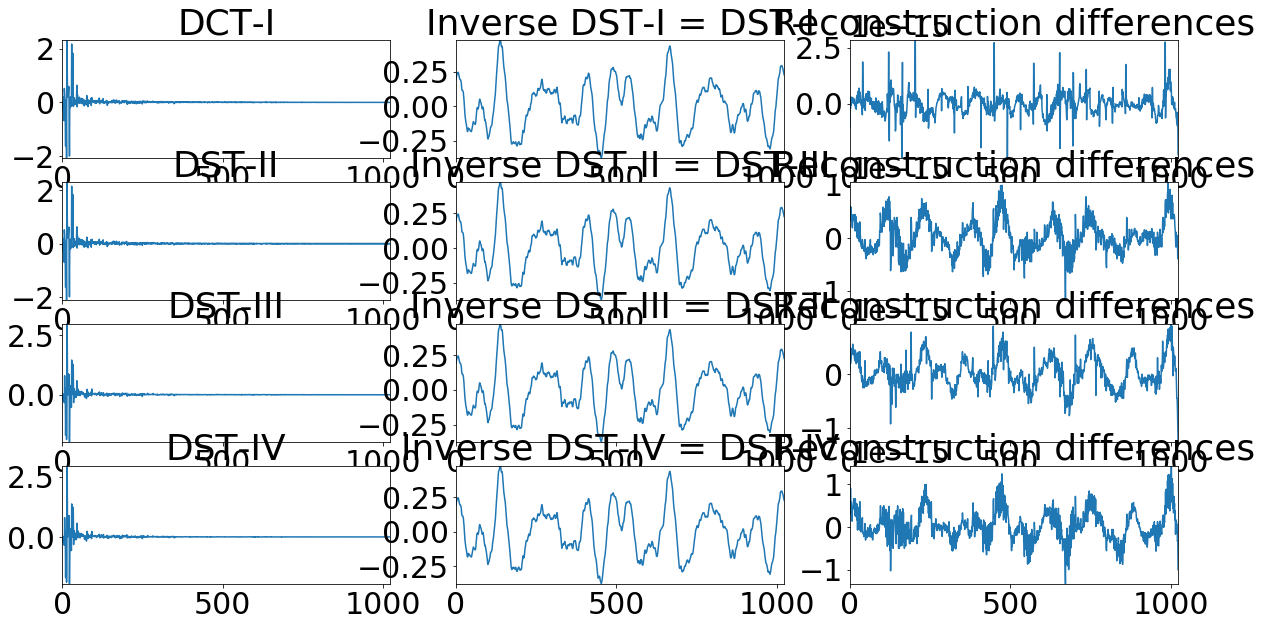

In [8]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import scipy.fftpack
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)
audio_signal = np.expand_dims(audio_signal, axis=1)

# Audio signal for a given window length, and one frame
window_length = 1024
audio_signal = audio_signal[0:window_length, :]

# DST-I, II, III, and IV
audio_dst1 = z.dst(audio_signal, 1)
audio_dst2 = z.dst(audio_signal, 2)
audio_dst3 = z.dst(audio_signal, 3)
audio_dst4 = z.dst(audio_signal, 4)

# Respective inverses, i.e., DST-I, II, III, and IV
audio_idst1 = z.dst(audio_dst1, 1)
audio_idst2 = z.dst(audio_dst2, 3)
audio_idst3 = z.dst(audio_dst3, 2)
audio_idst4 = z.dst(audio_dst4, 4)

# DST-I, II, III, and IV, respective inverses, and differences with the original signal displayed
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(4, 3, 1), plt.plot(audio_dst1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(4, 3, 2), plt.plot(audio_idst1), plt.autoscale(tight=True), plt.title("Inverse DST-I = DST-I")
plt.subplot(4, 3, 3), plt.plot(audio_signal-audio_idst1), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 4), plt.plot(audio_dst2), plt.autoscale(tight=True), plt.title("DST-II")
plt.subplot(4, 3, 5), plt.plot(audio_idst2), plt.autoscale(tight=True), plt.title("Inverse DST-II = DST-III")
plt.subplot(4, 3, 6), plt.plot(audio_signal-audio_idst2), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 7), plt.plot(audio_dst3), plt.autoscale(tight=True), plt.title("DST-III")
plt.subplot(4, 3, 8), plt.plot(audio_idst3), plt.autoscale(tight=True), plt.title("Inverse DST-III = DST-II")
plt.subplot(4, 3, 9), plt.plot(audio_signal-audio_idst3), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.subplot(4, 3, 10), plt.plot(audio_dst4), plt.autoscale(tight=True), plt.title("DST-IV")
plt.subplot(4, 3, 11), plt.plot(audio_idst4), plt.autoscale(tight=True), plt.title("Inverse DST-IV = DST-IV")
plt.subplot(4, 3, 12), plt.plot(audio_signal-audio_idst4), plt.autoscale(tight=True), plt.title("Reconstruction differences")
plt.show()

### <a id="mdct"></a>mdct Modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT)

```
import z
audio_mdct = z.mdct(audio_signal, window_function)
```

Arguments:

```
audio_signal: audio signal [number_samples, 0]
window_function: window function [window_length, 0]
audio_mdct: audio MDCT [number_frequencies, number_times]
```

Example: Compute and display the MDCT as used in the AC-3 audio coding format

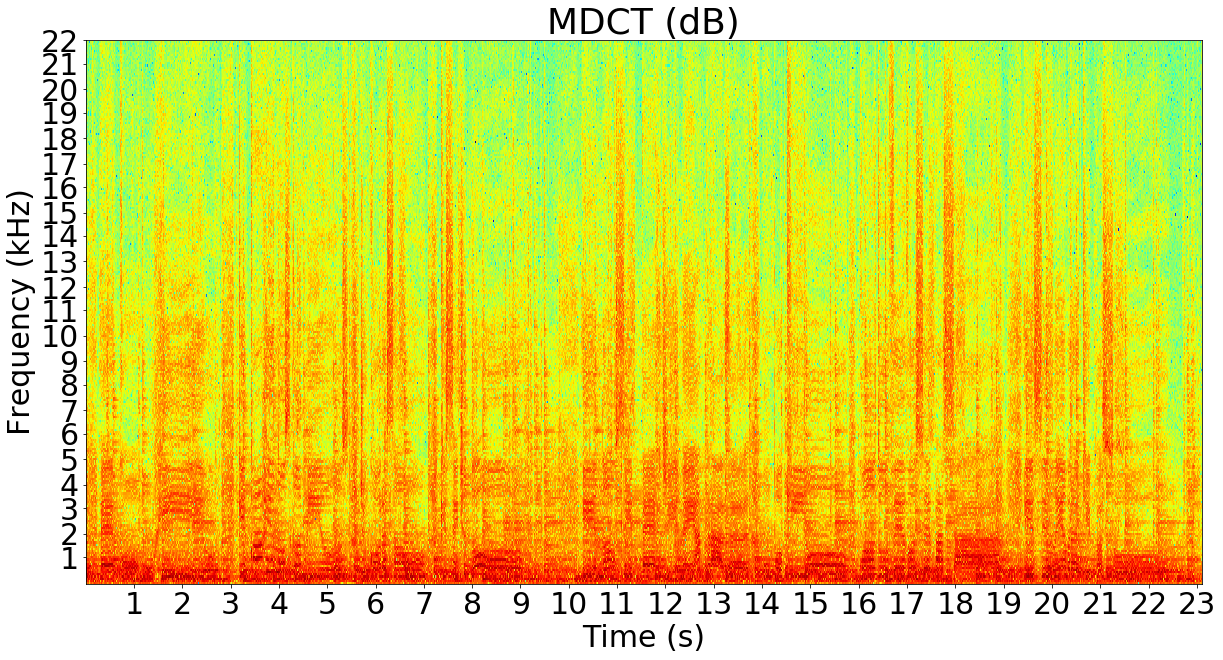

In [9]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0**(audio_signal.itemsize*8-1))
audio_signal = np.mean(audio_signal, 1)

# Kaiser-Bessel-derived (KBD) window as used in the AC-3 audio coding format
window_length = 512
alpha_value = 5
window_function = np.kaiser(int(window_length/2)+1, alpha_value*np.pi)
window_function2 = np.cumsum(window_function[1:int(window_length/2)])
window_function = np.sqrt(np.concatenate((window_function2, window_function2[int(window_length/2)::-1]))
                          / np.sum(window_function))

# MDCT
audio_mdct = z.mdct(audio_signal, window_function)

# MDCT displayed in dB, s, and kHz
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.imshow(20*np.log10(np.absolute(audio_mdct)), aspect='auto', cmap='jet', origin='lower')
plt.title('MDCT (dB)')
plt.xticks(np.round(np.arange(1, np.floor(len(audio_signal)/sample_rate)+1)*sample_rate/(window_length/2)),
           np.arange(1, int(np.floor(len(audio_signal)/sample_rate))+1))
plt.xlabel('Time (s)')
plt.yticks(np.round(np.arange(1e3, sample_rate/2+1, 1e3)/sample_rate*window_length),
           np.arange(1, int(sample_rate/2*1e3)+1))
plt.ylabel('Frequency (kHz)')
plt.show()

### <a id="imdct"></a>imdct Inverse modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT)

```
import z
audio_signal = z.imdct(audio_mdct, window_function)
```

Arguments:

```
audio_mdct: audio MDCT [number_frequencies, number_times]
window_function: window function [window_length, 0]
audio_signal: audio signal [number_samples, 0]
```

Example: Verify that the MDCT is perfectly invertible

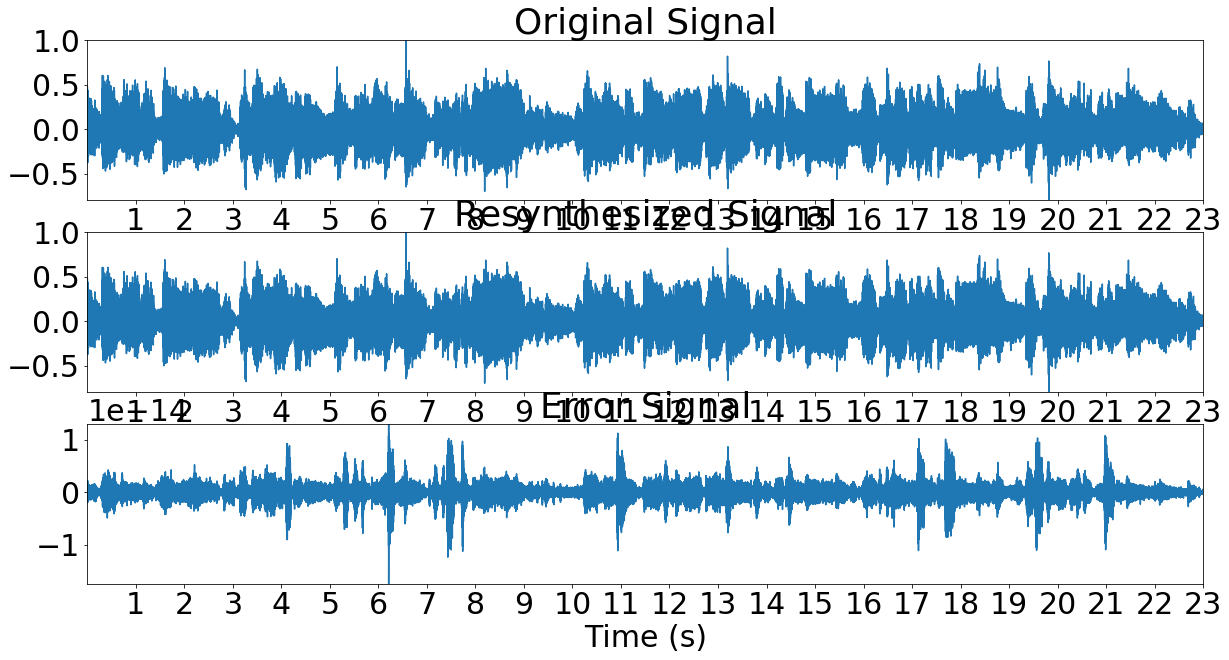

In [11]:
%matplotlib inline

# Import modules
import scipy.io.wavfile
import numpy as np
import z
import matplotlib.pyplot as plt

# Audio signal (normalized) averaged over its channels (expanded) and sample rate in Hz
sample_rate, audio_signal = scipy.io.wavfile.read('audio_file.wav')
audio_signal = audio_signal / (2.0 ** (audio_signal.itemsize * 8 - 1))
audio_signal = np.mean(audio_signal, 1)

# MDCT with a slope function as used in the Vorbis audio coding format
window_length = 2048
window_function = np.sin(np.pi / 2
                         * np.power(np.sin(np.pi / window_length * np.arange(0.5, window_length + 0.5)), 2))
audio_mdct = z.mdct(audio_signal, window_function)

# Inverse MDCT and error signal
audio_signal2 = z.imdct(audio_mdct, window_function)
audio_signal2 = audio_signal2[0:len(audio_signal)]
error_signal = audio_signal - audio_signal2

# Original, resynthesized, and error signals
plt.figure(figsize=(20,10))
plt.rc('font', size=30)
plt.subplot(3, 1, 1), plt.plot(audio_signal), plt.autoscale(tight=True), plt.title("Original Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 2), plt.plot(audio_signal2), plt.autoscale(tight=True), plt.title("Resynthesized Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.subplot(3, 1, 3), plt.plot(error_signal), plt.autoscale(tight=True), plt.title("Error Signal")
plt.xticks(np.arange(sample_rate, len(audio_signal), sample_rate),
           np.arange(1, int(np.floor(len(audio_signal) / sample_rate)) + 1))
plt.xlabel('Time (s)')
plt.show()